# 1. 数据集下载

路透社数据集是关于新闻的多类文本分类数据集，可以被划分为46个不同的主题。每个主题的样本数量不同，但是每个主题的训练集中至少有10个样本。取数据集中出现频率最高的前10000个单词组成词典，构建单词和索引的映射：

In [1]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

print('train data: ', len(train_data))
print('test data: ', len(test_data))

Using TensorFlow backend.


train data:  8982
test data:  2246


In [2]:
print('The 10th data in train dataset: \n', train_data[10])

The 10th data in train dataset: 
 [1, 245, 273, 207, 156, 53, 74, 160, 26, 14, 46, 296, 26, 39, 74, 2979, 3554, 14, 46, 4689, 4329, 86, 61, 3499, 4795, 14, 61, 451, 4329, 17, 12]


In [3]:
# 将索引解析为单词

# word_index是一个将单词映射为整数索引的字典
word_index = reuters.get_word_index()
# 键值颠倒，将整数映射为单词，构建reverse_word_index字典
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# 解码第一条评论，将索引值减去３，因为前三个数字默认为'padding', 'start of sequence', 'unknown'的保留索引值
decoded_review = ' '.join([reverse_word_index.get(i-3, '?') for i in train_data[0]])

In [4]:
print('the decoded review: \n', decoded_review)

the decoded review: 
 ? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


# 2. 准备数据

In [5]:
import numpy as np

def vectorize_sequences(sequences, dimension = 10000):
    # 先构造一个形状为(len(sequences), dimension)的全０矩阵
    results = np.zeros((len(sequences), dimension))
    # 根据序列的查询,将result[i]指定的索引设置为１
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# 将训练数据和测试数据进行one-hot编码
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

采用one-hot对labels进行分类数据向量化，即只有符合类别标签的位置是1,其余位置是0:

In [6]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

In [7]:
print('train data shape: ', x_train.shape)
print('test data shape: ', x_test.shape)
print('train label shape: ', one_hot_train_labels.shape)
print('test label shape: ', one_hot_test_labels.shape)

train data shape:  (8982, 10000)
test data shape:  (2246, 10000)
train label shape:  (8982, 46)
test label shape:  (2246, 46)


# 3. 构建神经网络

因为需要对46个类别进行分类，所以中间的隐层的维度需要进行相应的扩充，使用64个隐层节点构建神经网络。

输出层使用softmax作为激活函数。output[i]是样本属于第i类的概率，46类的概率总和是１。

In [8]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
# 编译模型，使用categorical_crossentropy（分类交叉熵）作为损失函数，用于衡量两个类别之间的概率分布距离
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 4. 测试神经网络

取1000个样本作为训练时的验证集，剩下的作为训练集。训练采用20epochs,使用512个样本进行小批次训练。

In [10]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [11]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 194us/step - loss: 2.5322 - acc: 0.4955 - val_loss: 1.7208 - val_acc: 0.6120
Epoch 2/20
7982/7982 [==============================] - 0s 58us/step - loss: 1.4452 - acc: 0.6879 - val_loss: 1.3459 - val_acc: 0.7060
Epoch 3/20
7982/7982 [==============================] - 0s 57us/step - loss: 1.0953 - acc: 0.7651 - val_loss: 1.1708 - val_acc: 0.7430
Epoch 4/20
7982/7982 [==============================] - 0s 57us/step - loss: 0.8697 - acc: 0.8165 - val_loss: 1.0793 - val_acc: 0.7590
Epoch 5/20
7982/7982 [==============================] - 0s 59us/step - loss: 0.7034 - acc: 0.8472 - val_loss: 0.9844 - val_acc: 0.7810
Epoch 6/20
7982/7982 [==============================] - 0s 59us/step - loss: 0.5667 - acc: 0.8802 - val_loss: 0.9411 - val_acc: 0.8040
Epoch 7/20
7982/7982 [==============================] - 0s 58us/step - loss: 0.4581 - acc: 0.

In [12]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

绘制条目之间的关系图：

__训练损失和验证损失__：

In [13]:
import matplotlib.pyplot as plt

val_loss = history.history['val_loss']
val_acc = history.history['val_acc']
loss = history.history['loss']
acc = history.history['acc']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


__训练准确率和测试准确率__:

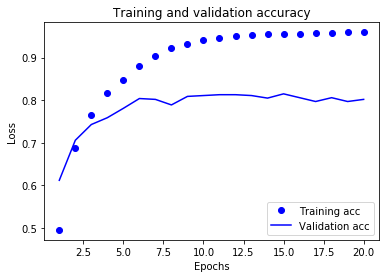

In [14]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 减少训练轮数，再次训练

In [16]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=8,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Train on 7982 samples, validate on 1000 samples
Epoch 1/8
7982/7982 [==============================] - 1s 76us/step - loss: 2.5398 - acc: 0.5226 - val_loss: 1.6733 - val_acc: 0.6570
Epoch 2/8
7982/7982 [==============================] - 0s 56us/step - loss: 1.3712 - acc: 0.7121 - val_loss: 1.2758 - val_acc: 0.7210
Epoch 3/8
7982/7982 [==============================] - 0s 57us/step - loss: 1.0136 - acc: 0.7781 - val_loss: 1.1303 - val_acc: 0.7530
Epoch 4/8
7982/7982 [==============================] - 0s 56us/step - loss: 0.7976 - acc: 0.8251 - val_loss: 1.0539 - val_acc: 0.7590
Epoch 5/8
7982/7982 [==============================] - 0s 57us/step - loss: 0.6393 - acc: 0.8624 - val_loss: 0.9754 - val_acc: 0.7920
Epoch 6/8
7982/7982 [==============================] - 0s 56us/step - loss: 0.5124 - acc: 0.8921 - val_loss: 0.9102 - val_acc: 0.8140
Epoch 7/8
7982/7982 [==============================] - 0s 56us/step - loss: 0.4124 - acc: 0.9137 - val_loss: 0.8932 - val_acc: 0.8210
Epoch 8/8
2246

In [17]:
results

[0.9845061219386086, 0.7836153161175423]

训练８轮的模型可以在测试集上获得78%的准确率，对于46类问题已经属于比较理想的分类结果。对于完全随机的路透社数据集分类,将获得19%的分类准确率。

In [18]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

0.19679430097951914

## 在新的数据上预测结果：

In [19]:
predictions = model.predict(x_test)

predictions是测试数据的分类结果，对于每一个测试数据都是46维的vector,且总和应该等于１。

In [20]:
predictions[0].shape

(46,)

In [21]:
np.sum(predictions[0])

0.99999994

在46维vector中，数字最大的一类是最终预测的类别：

In [22]:
np.argmax(predictions[0])

3

# 5. 减少隐层维度，重新测试

In [24]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 64us/step - loss: 2.7073 - acc: 0.4411 - val_loss: 2.0155 - val_acc: 0.5930
Epoch 2/20
7982/7982 [==============================] - 0s 43us/step - loss: 1.7341 - acc: 0.6183 - val_loss: 1.6573 - val_acc: 0.6100
Epoch 3/20
7982/7982 [==============================] - 0s 44us/step - loss: 1.4678 - acc: 0.6359 - val_loss: 1.5688 - val_acc: 0.6080
Epoch 4/20
7982/7982 [==============================] - 0s 43us/step - loss: 1.3273 - acc: 0.6446 - val_loss: 1.4833 - val_acc: 0.6170
Epoch 5/20
7982/7982 [==============================] - 0s 43us/step - loss: 1.2168 - acc: 0.6498 - val_loss: 1.4540 - val_acc: 0.6250
Epoch 6/20
7982/7982 [==============================] - 0s 43us/step - loss: 1.1265 - acc: 0.6753 - val_loss: 1.4326 - val_acc: 0.6350
Epoch 7/20
7982/7982 [==============================] - 0s 42us/step - loss: 1.0522 - acc: 0.6944 - val_loss: 1.4520 - val_acc: 0.6420
Epoch 8

当中间的隐层节点减少时，最后的准确率也会随之下降，说明当数据分类情况比较复杂时，中间需要足够的隐层维度才能保证充分学习到数据特征。